In [1]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import matplotlib.pyplot as plt

In [2]:
wine_quality = fetch_ucirepo(id=186)

# Pre-processing
df = wine_quality.data.original

def categorize_quality(quality):
    if quality < 7:
        return 'bad'
    else:
        return 'good'


df['quality_category'] = df['quality'].apply(categorize_quality)

red_wine_df = df[df['color'] == 'red']
white_wine_df = df[df['color'] == 'white']

df_array = [red_wine_df, white_wine_df, df]


In [3]:

rf = RandomForestClassifier(random_state=42)
df_names = ['Red Wine', 'White Wine', 'Combined Wine']

def confusion_matrix_plot(y_test, y_pred, clf, model):
    # Create both normalized and raw confusion matrices
    cm_raw = confusion_matrix(y_test, y_pred)
    cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')  # Normalize by true class
    
    # Create side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Raw counts confusion matrix
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_raw, display_labels=clf.classes_)
    disp1.plot(cmap=plt.cm.Blues, ax=ax1, values_format='d')
    ax1.set_title(f'Confusion Matrix (Raw Counts)\n{model.__class__.__name__}')
    
    # Normalized confusion matrix (shows percentages for each true class)
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=clf.classes_)
    disp2.plot(cmap=plt.cm.Blues, ax=ax2, values_format='.2f')
    ax2.set_title(f'Confusion Matrix (Normalized)\n{model.__class__.__name__}')
    
    plt.tight_layout()
    plt.show()
    
    

def optimized_folds(model, X, y):
    best_score = 0
    best_folds = 0
    
    for folds in np.arange(2, 11):
        scores = cross_val_score(model, X, y, cv=folds, scoring='f1_macro')
        if scores.mean() > best_score:
            best_score = scores.mean()
            best_folds = folds
    
    print(f"Best Folds: {best_folds} | Best Score: {best_score}", end=" | ")
    return best_folds


def pr_curve(y_test, y_scores, model):
    
    precision, recall, _ = precision_recall_curve(y_test, y_scores, pos_label='good')
    
    # Calculate Average Precision (area under PR curve)
    ap_score = average_precision_score(y_test, y_scores, pos_label='good')
    
    # Calculate baseline (random classifier performance)
    baseline = len(y_test[y_test == 'good']) / len(y_test)
    
    plt.figure(figsize=(10, 7))
    plt.plot(recall, precision, linewidth=2, label=f'PR Curve (AP = {ap_score:.3f})')
    plt.axhline(y=baseline, color='red', linestyle='--', linewidth=1, 
                label=f'Random Baseline (AP = {baseline:.3f})')
    
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'Precision-Recall Curve for {model.__class__.__name__}', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Add text box with key metrics
    textstr = f'Average Precision: {ap_score:.3f}\nBaseline: {baseline:.3f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()
    
    return ap_score


def get_probability_scores(model, X_test):
    if hasattr(model, 'predict_proba'):
        # For models that support probability prediction
        probabilities = model.predict_proba(X_test)
        # Find the index of 'good' class
        good_index = list(model.classes_).index('good')
        return probabilities[:, good_index]
    elif hasattr(model, 'decision_function'):
        # For models with decision function (like SVM without probability)
        return model.decision_function(X_test)
    else:
        # Fallback: use predicted class as binary score (not ideal for PR curve)
        predictions = model.predict(X_test)
        return (predictions == 'good').astype(int)

Processing Red Wine DataFrame
Best Folds: 9 | Best Score: 0.6738202907721836 | Fitting 9 folds for each of 10 candidates, totalling 90 fits
Best parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 15, 'bootstrap': False}
              precision    recall  f1-score   support

         bad       0.93      0.99      0.96       415
        good       0.89      0.52      0.66        65

    accuracy                           0.93       480
   macro avg       0.91      0.76      0.81       480
weighted avg       0.93      0.93      0.92       480



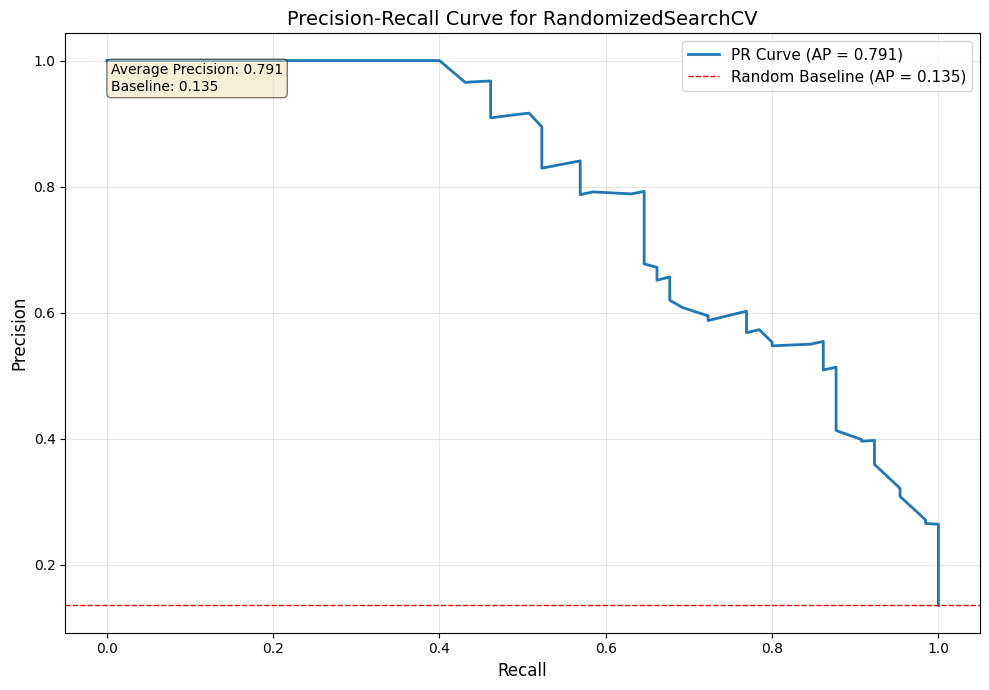

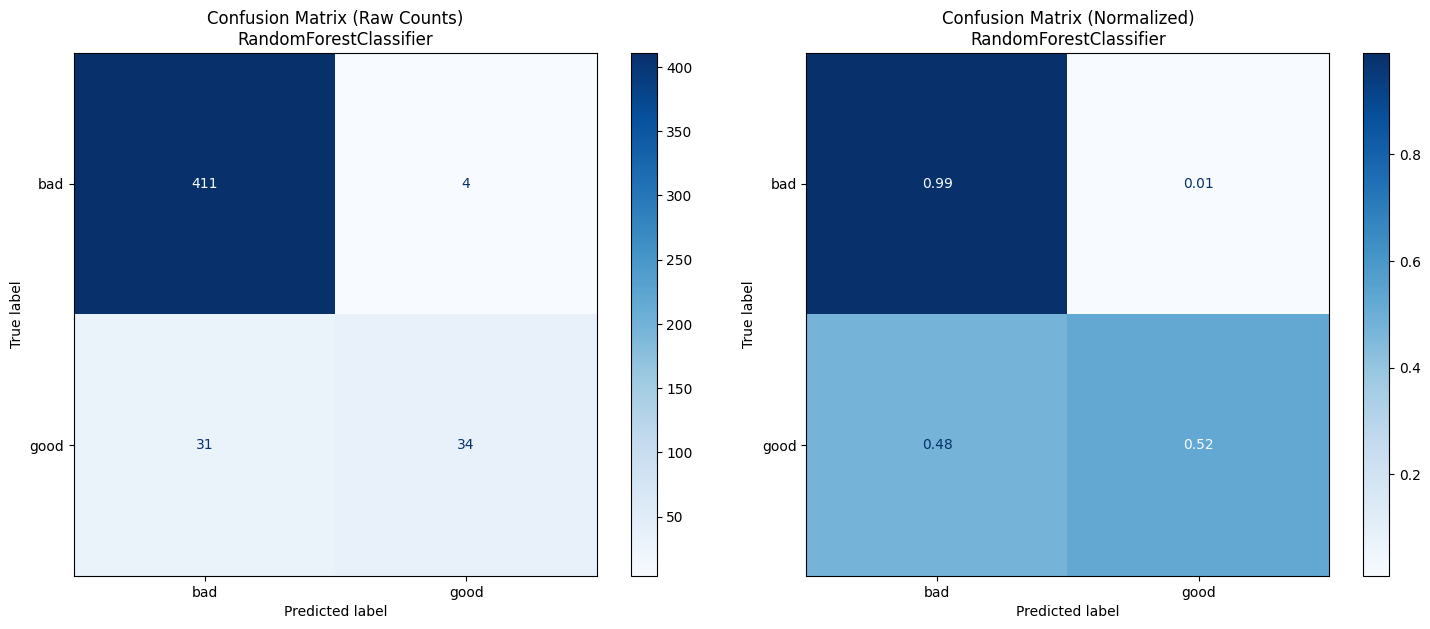

Processing White Wine DataFrame
Best Folds: 6 | Best Score: 0.6578056759010121 | Fitting 6 folds for each of 10 candidates, totalling 60 fits
Best parameters: {'n_estimators': 250, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 45, 'bootstrap': False}
              precision    recall  f1-score   support

         bad       0.89      0.97      0.93      1152
        good       0.83      0.56      0.67       318

    accuracy                           0.88      1470
   macro avg       0.86      0.76      0.80      1470
weighted avg       0.87      0.88      0.87      1470



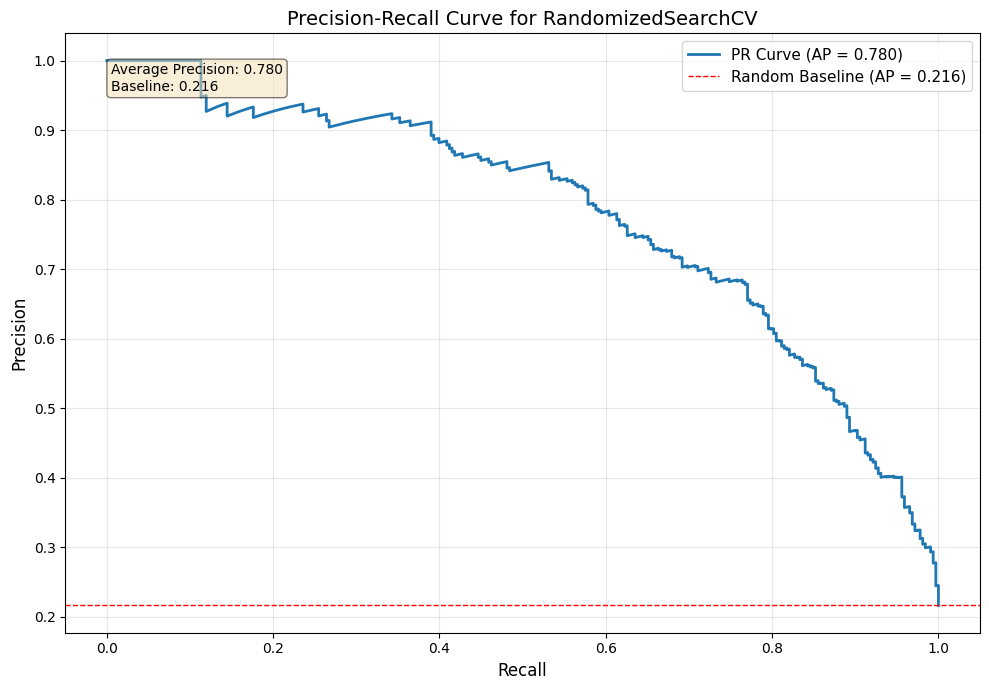

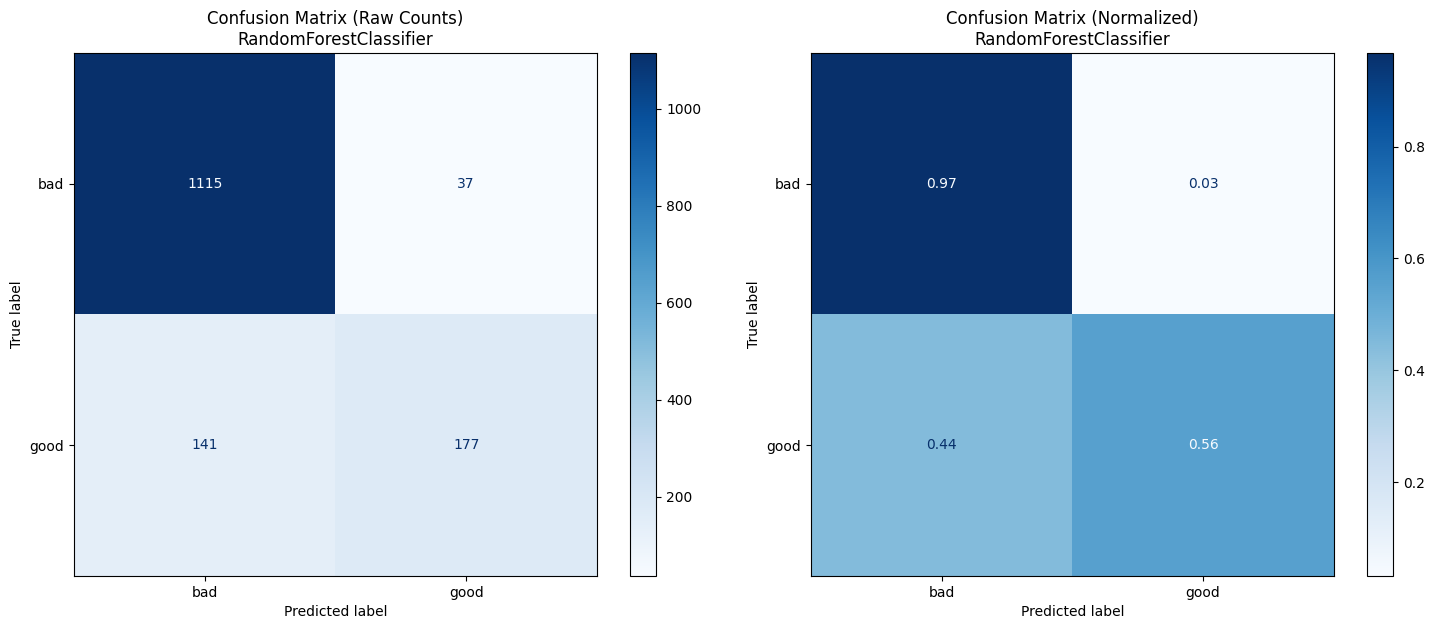

Processing Combined Wine DataFrame
Best Folds: 9 | Best Score: 0.6485572542583852 | Fitting 9 folds for each of 10 candidates, totalling 90 fits
Best parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 15, 'bootstrap': False}
              precision    recall  f1-score   support

         bad       0.90      0.96      0.93      1567
        good       0.76      0.57      0.65       383

    accuracy                           0.88      1950
   macro avg       0.83      0.76      0.79      1950
weighted avg       0.87      0.88      0.87      1950



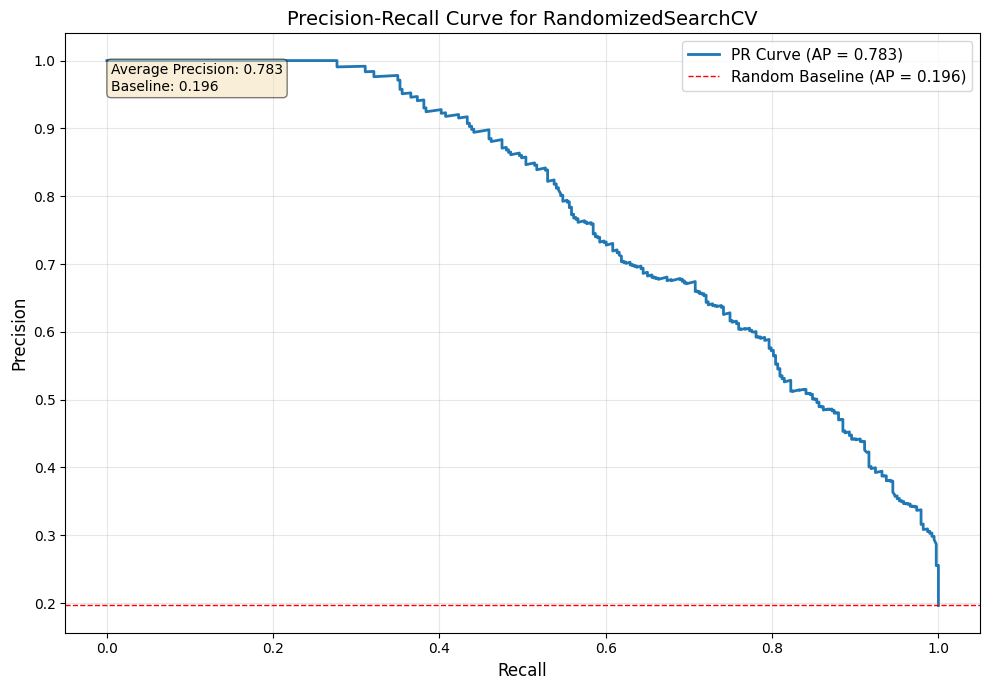

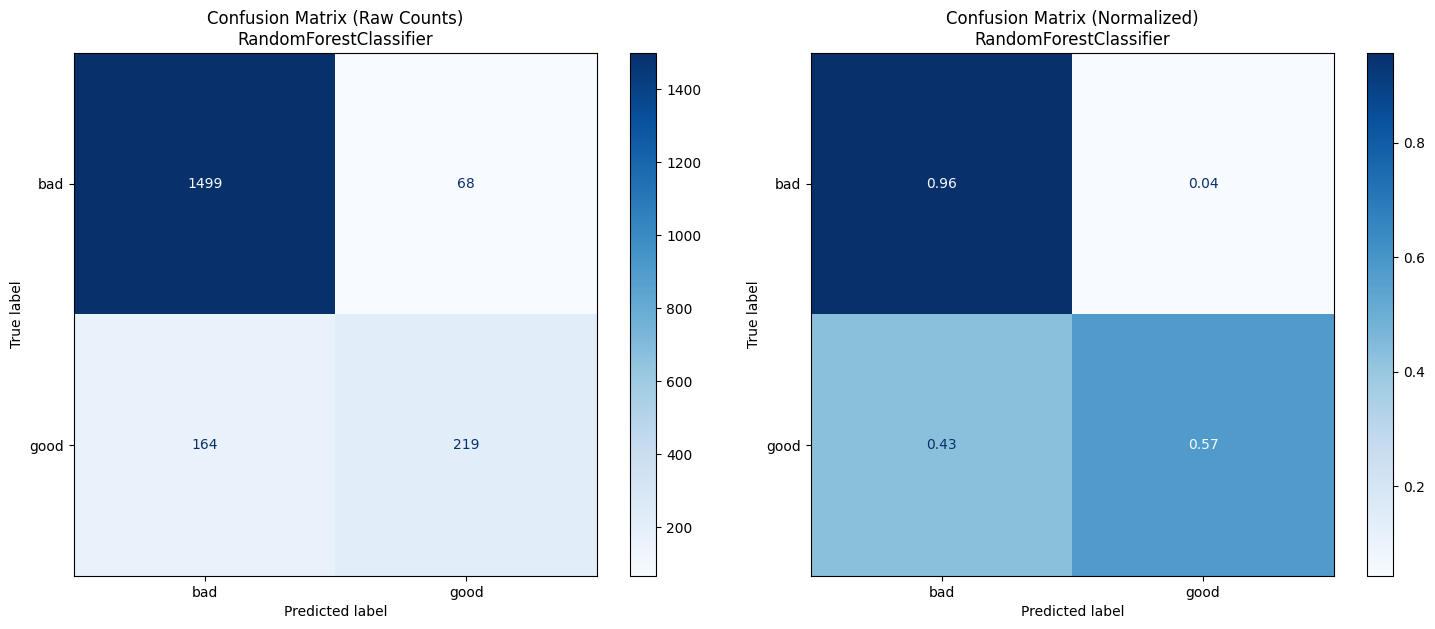

In [4]:
for i, df in enumerate(df_array):
    print("=" * 40)
    print(f"Processing {df_names[i]} DataFrame")
    print("=" * 40)
    
    X = df.drop(['quality', 'quality_category', 'color'], axis=1)
    y = df['quality_category']

    fold_options = np.arange(5, 15)
    best_folds = optimized_folds(rf, X, y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Randomized Search CV (faster alternative to Grid Search)
    param_dist = {
        'n_estimators': np.arange(50, 300, 50),
        'max_depth': [None] + list(np.arange(5, 50, 5)),
        'min_samples_split': np.arange(2, 20, 2),
        'min_samples_leaf': np.arange(1, 10, 1),
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False]
    }

    rf = RandomForestClassifier(random_state=42)

    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        cv=best_folds,
        n_jobs=-1,  # Use all available cores
        scoring='accuracy',
        random_state=42,
        verbose=1 # how much output to show during the search
    )

    random_search.fit(X_train, y_train)

    print(f"Best parameters: {random_search.best_params_}")

    # Evaluation metrics
    y_pred = random_search.predict(X_test)

    print(classification_report(y_test, y_pred))

    y_scores = get_probability_scores(random_search, X_test)
    ap_score = pr_curve(y_test, y_scores, random_search)

    confusion_matrix_plot(y_test, y_pred, random_search, rf)